### 프로젝트 소개
- SNS서비스(익명투표앱) 특정기간동안 서비스 내부데이터 및 유저 이벤트 데이터를 통해 프로덕트 데이터 및 서비스 이용패턴을 분석

- 학교/학급, 친구 요청, 질문, 투표, 포인트 : 내부데이터
- 사용자 이용패턴, 프로덕트 데이터, 분석 솔루션인 핵클에 적재된 서비스의 이벤트 데이터

### 내용
관심있는 주제 선정 -> 필요한 정보 필터링 -> 결론도출

대상 : 10대 청소년
분석대상 : 익명투표 모바일 앱
사용방법 : 사용자는 학교, 학년, 반을 선택하여 가입 -> 랜덤질문에 익명으로 투표
앱 기능 : 
    - 가입 및 프로필 설정 : 명의확인 및 번호 인증 -> 학교,학년반 정보입력 후 가입 -> 가입정보로 연동화, 친구추천기능 
    - 질문 및 투표 참여 : 랜덤질문에 맞는 친구선택 -> 선택된 친구는 질문확인가능 -> 질문은 연속 10개 제시 -> 대답스킵가능
    - 투표확인 및 흰트사용 : 투표에 선택된 사람은 알람으로 확인 -> 포인트(하트)로 선택한사람 초성학인가능
    - 친구 추가 및 상호작용 : 친구추가, 받은투표 답장기능(상호작용가능)

In [1]:
!python --version

Python 3.11.6


In [2]:
%pip install google-cloud-storage

Note: you may need to restart the kernel to use updated packages.


## 라이브러리

In [6]:
import os
from google.cloud import storage
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gcsfs
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# JSON 키 파일 경로 설정
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/home/jovyan/work/secrets/sprintda05-hojae2-81f15ecb4816.json'

try:
    client = storage.Client()
    print(f"✅ 연결 성공! 프로젝트: {client.project}")
    buckets = list(client.list_buckets())
    print(f"버킷 개수: {len(buckets)}")
except Exception as e:
    print(f"❌ 연결 실패: {e}")

✅ 연결 성공! 프로젝트: sprintda05-hojae2
버킷 개수: 1


## data

In [ ]:
# GCS에서 Parquet 파일 불러오기 및 형식 확인
print("\n--- 2. GCS Parquet 파일 로드 및 형식 확인 ---")
gcs_parquet_path = "gs://sprintda05_final_project/hackle/hackle_events.parquet"

print(f"📂 다음 Parquet 파일을 불러옵니다: {gcs_parquet_path}")

# pandas를 사용하여 Parquet 파일 불러오기
# 'engine'을 'pyarrow'로 명시하여 확실하게 pyarrow 사용
# gcsfs가 설치되어 있다면 pandas는 gs:// 경로를 자동으로 처리
hackle_events = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

print("\n✅ Parquet 파일 로드 성공!")

print("\n--- 데이터프레임 상위 5개 행 (hackle_events.head()) ---")
print(hackle_events.head())

print("\n--- 데이터프레임 정보 (hackle_events.info()) ---")
# 각 컬럼의 이름, Non-Null 개수, 데이터 타입(Dtype) 확인
hackle_events.info()

print("\n--- 데이터프레임 기술 통계 (hackle_events.describe()) ---")
# 숫자형 컬럼에 대한 통계 정보 확인
print(hackle_events.describe(include='all')) # 모든 컬럼 타입 포함

print(f"\n--- 데이터프레임 행과 열 개수 (df.shape): {hackle_events.shape} ---")

print("\n--- 데이터프레임 컬럼 목록 (df.columns) ---")
print(hackle_events.columns.tolist())


--- 2. GCS Parquet 파일 로드 및 형식 확인 ---
📂 다음 Parquet 파일을 불러옵니다: gs://sprintda05_final_project/hackle/hackle_events.parquet


- 이벤트 발생시기
- 세션 구분 기준 (시간 혹은 앱 종료)
- 이벤트 간 논리적 순서(일반적인 사용자 여정)

In [ ]:
# display(hackle_events)

In [ ]:
hackle_events['item_name'].unique()

NameError: name 'hackle_events' is not defined

In [ ]:
hackle_events['page_name'].unique()

array(['', 'notice', 'home', 'profile', '학교선택', '학년선택', '반선택', '번호인증',
       '성별선택', '아이디입력', '프사설정', 'invite', '이름입력'], dtype=object)

In [ ]:
hackle_events['event_datetime'] = pd.to_datetime(hackle_events['event_datetime'])

hackle_events['hour'] = hackle_events['event_datetime'].dt.hour
event_by_hour = hackle_events.groupby('hour').size()

<Axes: xlabel='hour'>

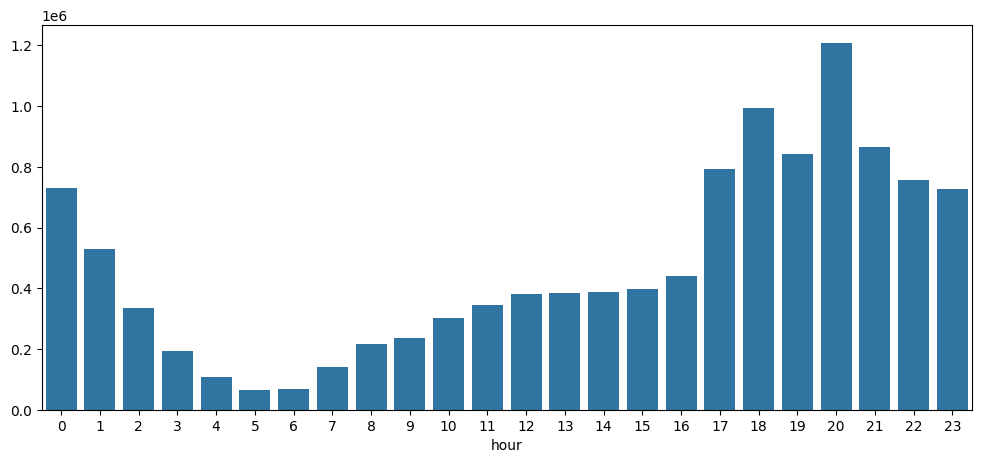

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(event_by_hour)

In [ ]:
# 세션별 이벤트 수 (활동량)
session_counts = hackle_events.groupby('session_id').size().reset_index(name='event_count')

In [ ]:
session_counts['event_count'].describe()

count    253616.000000
mean         45.112765
std         115.665378
min           1.000000
25%          10.000000
50%          22.000000
75%          45.000000
max        8157.000000
Name: event_count, dtype: float64

In [ ]:
session_times = hackle_events.groupby('session_id')['event_datetime'].min().reset_index()
session_times = session_times.sort_values(by='event_datetime')

<Axes: xlabel='event_datetime', ylabel='Count'>

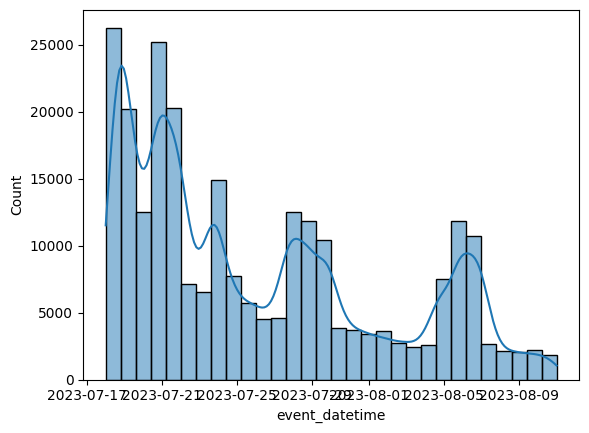

In [ ]:
sns.histplot(session_times['event_datetime'], bins=30, kde=True)

In [ ]:
# '$session_start' 값을 가진 event_key만 필터링
session_start_events = hackle_events[hackle_events['event_key'] == '$session_start']
session_start_events.head()

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id,hour
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN,19
15,00001ec5-83c0-4478-9eae-53171e10d958,2023-07-23 21:03:31,$session_start,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,00001ec5-83c0-4478-9eae-53171e10d958,,,27.0,278.0,1246.0,NaN,21
20,00002490-09ce-4962-9be6-f7495127ac67,2023-07-23 15:27:49,$session_start,NOdvth0cBJV15fIP2sXxMAMEUEr1,00002490-09ce-4962-9be6-f7495127ac67,,,NaN,NaN,NaN,NaN,15
29,000030fe-6893-4b09-957c-5d00228abc6e,2023-08-06 21:10:26,$session_start,eGdsDZKBmsVfTYbVMBdrs63IzOI2,000030fe-6893-4b09-957c-5d00228abc6e,,,29.0,90.0,2182.0,NaN,21
44,000040af-4504-4182-ae02-f930433ba1a9,2023-08-06 13:42:44,$session_start,2D0AD23B-5027-425C-8EF5-EC44AD235550,000040af-4504-4182-ae02-f930433ba1a9,,,67.0,522.0,278.0,NaN,13


In [ ]:
session_start_events['event_datetime'] = pd.to_datetime(session_start_events['event_datetime'])
session_start_events['event_datetime']

/tmp/ipykernel_11193/2260056344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_start_events['event_datetime'] = pd.to_datetime(session_start_events['event_datetime'])


0          2023-07-18 19:40:17
15         2023-07-23 21:03:31
20         2023-07-23 15:27:49
29         2023-08-06 21:10:26
44         2023-08-06 13:42:44
                   ...        
11441292   2023-07-26 17:02:08
11441293   2023-07-26 01:51:13
11441305   2023-07-27 18:52:26
11441310   2023-07-29 18:09:59
11441318   2023-07-22 02:31:16
Name: event_datetime, Length: 1036852, dtype: datetime64[ms]

<Axes: ylabel='event_datetime'>

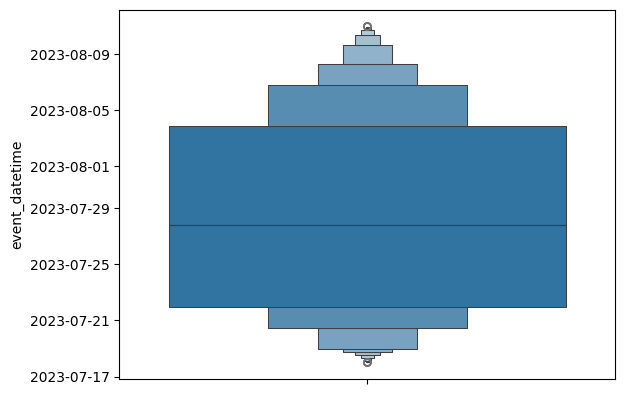

In [ ]:
sns.boxenplot(session_start_events['event_datetime'])

- 이벤트 데이터 대상 기간: 2023-07-11 ~ 2023-08-04 (약 4주)

In [ ]:
# 특정 session_id 예시로 이벤트 흐름 보기
example = hackle_events[hackle_events['session_id'] == '4OzYh3seq3VKytpSn5pvQkZNQii1']
example = example.sort_values('event_datetime')
example[['event_datetime', 'event_key']]

,event_datetime,event_key
0,2023-07-18 19:40:17,$session_start
1264531,2023-07-18 19:40:17,launch_app
7189055,2023-07-18 19:40:17,$session_end
2359188,2023-07-18 19:40:21,$session_start
4901766,2023-07-31 19:11:17,launch_app
...,...,...
550286,2023-07-31 19:15:21,click_bottom_navigation_timeline
6313439,2023-07-31 19:15:26,click_bottom_navigation_lab
5515904,2023-07-31 19:15:26,view_lab_tap
749702,2023-07-31 19:15:28,view_profile_tap


In [ ]:
# 해당 세션의 시간 범위 계산
example2 = hackle_events[hackle_events['session_id'] == '4OzYh3seq3VKytpSn5pvQkZNQii1']
example2 = example.sort_values('event_datetime')

display(example2)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id,hour
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN,19
1264531,1c4db97a-4231-4a9b-b1c5-425bac901303,2023-07-18 19:40:17,launch_app,4OzYh3seq3VKytpSn5pvQkZNQii1,1c4db97a-4231-4a9b-b1c5-425bac901303,,,NaN,NaN,NaN,NaN,19
7189055,a0d6fde2-d574-4a31-b61b-f0bdeee6548d,2023-07-18 19:40:17,$session_end,4OzYh3seq3VKytpSn5pvQkZNQii1,a0d6fde2-d574-4a31-b61b-f0bdeee6548d,,,NaN,NaN,NaN,NaN,19
2359188,34c64ad0-77aa-401f-9bf3-8c04cd2357ae,2023-07-18 19:40:21,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,34c64ad0-77aa-401f-9bf3-8c04cd2357ae,,,NaN,NaN,NaN,NaN,19
4901766,6d94b9ee-1539-43ab-ad1c-89efdf746ab3,2023-07-31 19:11:17,launch_app,4OzYh3seq3VKytpSn5pvQkZNQii1,6d94b9ee-1539-43ab-ad1c-89efdf746ab3,,,51.0,191.0,1708.0,NaN,19
...,...,...,...,...,...,...,...,...,...,...,...,...
550286,0c4f13aa-a989-46b9-b714-a1959ead58ed,2023-07-31 19:15:21,click_bottom_navigation_timeline,4OzYh3seq3VKytpSn5pvQkZNQii1,0c4f13aa-a989-46b9-b714-a1959ead58ed,,,51.0,192.0,1719.0,NaN,19
6313439,8d3659c0-9b06-405f-a702-abfa7249c959,2023-07-31 19:15:26,click_bottom_navigation_lab,4OzYh3seq3VKytpSn5pvQkZNQii1,8d3659c0-9b06-405f-a702-abfa7249c959,,,51.0,192.0,1719.0,NaN,19
5515904,7b5766e1-d62b-4d07-bbd8-8b07ee47030e,2023-07-31 19:15:26,view_lab_tap,4OzYh3seq3VKytpSn5pvQkZNQii1,7b5766e1-d62b-4d07-bbd8-8b07ee47030e,,,51.0,192.0,1719.0,NaN,19
749702,10c0e8d3-8e78-4ba8-8bf6-b3d0c4918204,2023-07-31 19:15:28,view_profile_tap,4OzYh3seq3VKytpSn5pvQkZNQii1,10c0e8d3-8e78-4ba8-8bf6-b3d0c4918204,,,51.0,192.0,1719.0,NaN,19


In [ ]:
start_time = example['event_datetime'].min()
end_time = example['event_datetime'].max()

## 전처리 
- 혼자 불러와서 전처리 -> 중복제거 -> 하나의 데이터프레임을 만들기 (하나의 함수를 만들기) 변수명 : df

In [6]:
df = pd.read_parquet(gcs_parquet_path, engine='pyarrow')
print(df.head())

NameError: name 'gcs_parquet_path' is not defined

In [ ]:

print(df.columns)

print(df.shape)

print(df.info())

print(df.describe(include='all'))

Index(['event_id', 'event_datetime', 'event_key', 'session_id', 'id',
       'item_name', 'page_name', 'friend_count', 'votes_count',
       'heart_balance', 'question_id'],
      dtype='object')
(11441319, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB
None
                                    event_id              event_datetime  \
count                               11441319        

In [ ]:
full_duplicates = df.duplicated(keep=False)
partial_duplicates = df.duplicated(subset=['session_id', 'event_datetime', 'event_key'], keep=False)

print(f"🔁 완전 중복 행 수: {full_duplicates.sum():,}")
print(f"🌀 부분 중복 행 수: {partial_duplicates.sum():,}")

🔁 완전 중복 행 수: 0
🌀 부분 중복 행 수: 346,890


In [ ]:
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"🧹 중복 제거: {before - after}개 제거됨")

🧹 중복 제거: 0개 제거됨


In [ ]:
# elif table_name == '**le_events':
#             # 이벤트: 동일 세션+시간 중복
#             event_duplicates = df.duplicated(subset=['session_id', 'event_datetime', 'event_key']).sum()
#             print(f"• (세션, 시간, 이벤트) 중복: {event_duplicates:,}개")

df = df.drop_duplicates(
        subset=['session_id', 'event_datetime', 'event_key'],
        keep='last'  # last 값 남김
    ).reset_index(drop=True)

In [ ]:


def preprocess_hackle_events(parquet_path: str, keep: str = 'last') -> pd.DataFrame:
    
    df = pd.read_parquet(parquet_path, engine='pyarrow')

    # 중복 제거
    subset_cols = ['session_id', 'event_datetime', 'event_key']
    before = len(df)
    df = df.drop_duplicates(subset=subset_cols, keep=keep)
    after = len(df)
    print(f"중복 제거: {before - after:,}건 제거 ({(before - after)/before*100:.2f}%)")

    df['event_datetime'] = pd.to_datetime(df['event_datetime'])

    # 결측치 처리
    df['friend_count'] = df['friend_count'].fillna(0).astype(int)
    df['page_name'] = df['page_name'].fillna('unknown')

    # 불필요한 컬럼 제거
    drop_cols = [col for col in ['id'] if col in df.columns]
    df = df.drop(columns=drop_cols)

    print(f"✅ 최종 데이터 행 수: {len(df):,}")
    return df

df.shape

(11245459, 11)

## 불러오기

In [8]:

fs = gcsfs.GCSFileSystem()

file_paths = fs.glob("sprintda05_final_project/votes/*.parquet")
file_paths = ["gs://" + path for path in file_paths]

votes_data = {}

for path in file_paths:
    table_name = path.split("/")[-1].replace(".parquet", "")
    print(f"📥 불러오는 중: {table_name}")
    votes_data[table_name] = pd.read_parquet(path, engine='pyarrow')

print("\n✅ 모든 테이블 불러오기 완료")
print(f"총 {len(votes_data)}개 테이블 로드됨")

📥 불러오는 중: accounts_attendance
📥 불러오는 중: accounts_blockrecord
📥 불러오는 중: accounts_failpaymenthistory
📥 불러오는 중: accounts_friendrequest
📥 불러오는 중: accounts_group
📥 불러오는 중: accounts_nearbyschool
📥 불러오는 중: accounts_paymenthistory
📥 불러오는 중: accounts_pointhistory
📥 불러오는 중: accounts_school
📥 불러오는 중: accounts_timelinereport
📥 불러오는 중: accounts_user
📥 불러오는 중: accounts_user_contacts
📥 불러오는 중: accounts_userquestionrecord
📥 불러오는 중: accounts_userwithdraw
📥 불러오는 중: event_receipts
📥 불러오는 중: events
📥 불러오는 중: polls_question
📥 불러오는 중: polls_questionpiece
📥 불러오는 중: polls_questionreport
📥 불러오는 중: polls_questionset
📥 불러오는 중: polls_usercandidate

✅ 모든 테이블 불러오기 완료
총 21개 테이블 로드됨


In [9]:
votes_data.keys()
# 각 테이블의 상위 5개 행 출력
for table_name, df in votes_data.items():
    print(f"\n--- {table_name} 상위 5개 행 ---")
    print(df.head())


--- accounts_attendance 상위 5개 행 ---
   id                               attendance_date_list  user_id
0   1  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1446852
1   2  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1359398
2   3  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1501542
3   4  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1507767
4   5  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1287453

--- accounts_blockrecord 상위 5개 행 ---
   id              reason          created_at  block_user_id  user_id
0   1               그냥... 2023-05-04 23:01:53         867483   878476
1   2         친구 사이가 어색해짐 2023-05-05 01:17:08         867190   867564
2   3  나랑 관련 없는 질문을 자꾸 보냄 2023-05-05 01:50:55         875110   875261
3   6               그냥... 2023-05-05 05:21:52         883696   883511
4   7               그냥... 2023-05-05 06:40:34         871349   870177

--- accounts_failpaymenthistory 상위 5개 행 ---
   id   productId phone_type          created_at  user_id
0   6 

In [10]:

# 각 테이블의 정보 출력
for table_name, df in votes_data.items():
    print(f"\n--- {table_name} 정보 ---")
    df.info()



--- accounts_attendance 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB

--- accounts_blockrecord 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory u

In [11]:
# 각 테이블의 기술 통계 출력
for table_name, df in votes_data.items():
    print(f"\n--- {table_name} 기술 통계 ---")
    print(df.describe(include='all'))  # 모든 컬럼 타입 포함




--- accounts_attendance 기술 통계 ---
                   id attendance_date_list       user_id
count   349637.000000               349637  3.496370e+05
unique            NaN               128837           NaN
top               NaN                   []           NaN
freq              NaN                20945           NaN
mean    180550.143772                  NaN  1.247187e+06
std     104168.322237                  NaN  2.127986e+05
min          1.000000                  NaN  8.321510e+05
25%      90432.000000                  NaN  1.065813e+06
50%     180749.000000                  NaN  1.261234e+06
75%     270674.000000                  NaN  1.437486e+06
max     360505.000000                  NaN  1.583730e+06

--- accounts_blockrecord 기술 통계 ---
                  id   reason                     created_at  block_user_id  \
count   19482.000000    19482                          19482   1.948200e+04   
unique           NaN        7                            NaN            NaN   
top     

In [12]:
# 각 테이블의 행과 열 개수 출력
for table_name, df in votes_data.items():
    print(f"\n--- {table_name} 행과 열 개수 (df.shape) ---")
    print(df.shape)




--- accounts_attendance 행과 열 개수 (df.shape) ---
(349637, 3)

--- accounts_blockrecord 행과 열 개수 (df.shape) ---
(19482, 5)

--- accounts_failpaymenthistory 행과 열 개수 (df.shape) ---
(163, 5)

--- accounts_friendrequest 행과 열 개수 (df.shape) ---
(17147175, 6)

--- accounts_group 행과 열 개수 (df.shape) ---
(84515, 4)

--- accounts_nearbyschool 행과 열 개수 (df.shape) ---
(59500, 4)

--- accounts_paymenthistory 행과 열 개수 (df.shape) ---
(95140, 5)

--- accounts_pointhistory 행과 열 개수 (df.shape) ---
(2338918, 5)

--- accounts_school 행과 열 개수 (df.shape) ---
(5951, 4)

--- accounts_timelinereport 행과 열 개수 (df.shape) ---
(208, 6)

--- accounts_user 행과 열 개수 (df.shape) ---
(677085, 16)

--- accounts_user_contacts 행과 열 개수 (df.shape) ---
(5063, 4)

--- accounts_userquestionrecord 행과 열 개수 (df.shape) ---
(1217558, 12)

--- accounts_userwithdraw 행과 열 개수 (df.shape) ---
(70764, 3)

--- event_receipts 행과 열 개수 (df.shape) ---
(309, 5)

--- events 행과 열 개수 (df.shape) ---
(3, 6)

--- polls_question 행과 열 개수 (df.shape) ---
(5025, 3)


In [13]:
# 각 테이블의 컬럼 목록 출력
for table_name, df in votes_data.items():
    print(f"\n--- {table_name} 컬럼 목록 (df.columns) ---")
    print(df.columns.tolist())




--- accounts_attendance 컬럼 목록 (df.columns) ---
['id', 'attendance_date_list', 'user_id']

--- accounts_blockrecord 컬럼 목록 (df.columns) ---
['id', 'reason', 'created_at', 'block_user_id', 'user_id']

--- accounts_failpaymenthistory 컬럼 목록 (df.columns) ---
['id', 'productId', 'phone_type', 'created_at', 'user_id']

--- accounts_friendrequest 컬럼 목록 (df.columns) ---
['id', 'status', 'created_at', 'updated_at', 'receive_user_id', 'send_user_id']

--- accounts_group 컬럼 목록 (df.columns) ---
['id', 'grade', 'class_num', 'school_id']

--- accounts_nearbyschool 컬럼 목록 (df.columns) ---
['id', 'distance', 'nearby_school_id', 'school_id']

--- accounts_paymenthistory 컬럼 목록 (df.columns) ---
['id', 'productId', 'phone_type', 'created_at', 'user_id']

--- accounts_pointhistory 컬럼 목록 (df.columns) ---
['id', 'delta_point', 'created_at', 'user_id', 'user_question_record_id']

--- accounts_school 컬럼 목록 (df.columns) ---
['id', 'address', 'student_count', 'school_type']

--- accounts_timelinereport 컬럼 목록 (df.c

In [14]:
    
# 각 테이블의 고유한 값 개수 출력
for table_name, df in votes_data.items():
    print(f"\n--- {table_name} 고유한 값 개수 ---")
    for col in df.select_dtypes(include=['object']).columns:
        unique_count = df[col].nunique()
        print(f"{col}: {unique_count}개 고유 값")


--- accounts_attendance 고유한 값 개수 ---
attendance_date_list: 128837개 고유 값

--- accounts_blockrecord 고유한 값 개수 ---
reason: 7개 고유 값

--- accounts_failpaymenthistory 고유한 값 개수 ---
productId: 3개 고유 값
phone_type: 2개 고유 값

--- accounts_friendrequest 고유한 값 개수 ---
status: 3개 고유 값

--- accounts_group 고유한 값 개수 ---

--- accounts_nearbyschool 고유한 값 개수 ---

--- accounts_paymenthistory 고유한 값 개수 ---
productId: 4개 고유 값
phone_type: 2개 고유 값

--- accounts_pointhistory 고유한 값 개수 ---

--- accounts_school 고유한 값 개수 ---
address: 278개 고유 값
school_type: 2개 고유 값

--- accounts_timelinereport 고유한 값 개수 ---
reason: 5개 고유 값

--- accounts_user 고유한 값 개수 ---
gender: 2개 고유 값
friend_id_list: 674117개 고유 값
block_user_id_list: 11685개 고유 값
hide_user_id_list: 74995개 고유 값
ban_status: 4개 고유 값

--- accounts_user_contacts 고유한 값 개수 ---
invite_user_id_list: 928개 고유 값

--- accounts_userquestionrecord 고유한 값 개수 ---
status: 3개 고유 값
answer_status: 3개 고유 값

--- accounts_userwithdraw 고유한 값 개수 ---
reason: 8개 고유 값

--- event_receipts 고유한 값 개수 --

## 데이터 탐색 시각화

In [16]:
votes_data['accounts_user'].head()
votes_data['accounts_user'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 no

In [17]:
votes_data['accounts_userwithdraw'].head()
votes_data['accounts_userwithdraw'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70764 entries, 0 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          70764 non-null  int64         
 1   reason      70764 non-null  object        
 2   created_at  70764 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ MB


In [18]:
users = votes_data['accounts_user'].copy()
withdraws = votes_data['accounts_userwithdraw'].copy()

In [19]:
# 일별 집계
daily_joins = users['created_at'].value_counts().sort_index()
daily_withdraws = withdraws['created_at'].value_counts().sort_index()

In [20]:
summary = pd.DataFrame({
    'johned counts': daily_joins,
    'withdraws counts': daily_withdraws
}).fillna(0)

In [21]:
summary['withdraws(%)'] = (summary['withdraws counts'] / summary['johned counts']) * 100
summary = summary.fillna(0)

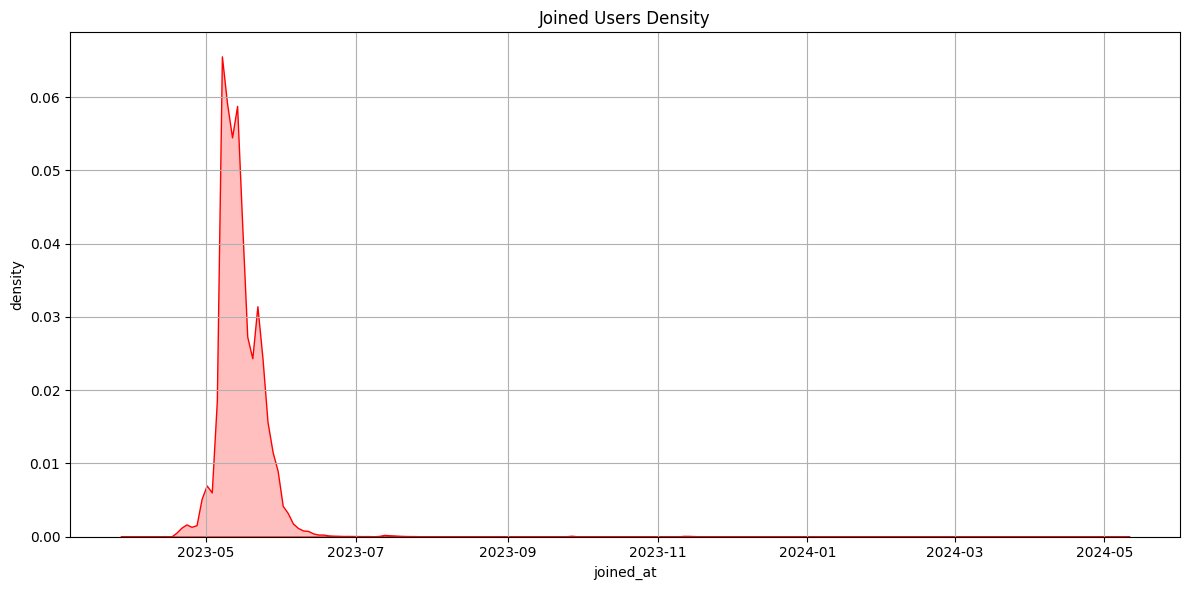

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(users['created_at'], bw_adjust=0.5, fill=True, color='RED')
plt.title("Joined Users Density")
plt.xlabel("joined_at")
plt.ylabel("density")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
top_reasons = (
    withdraws['reason']
    .value_counts()
    .head(10)
    .rename_axis('탈퇴 사유')    
    .reset_index(name='탈퇴자 수')  
)

top_reasons

,탈퇴 사유,탈퇴자 수
0,기타 이유,40301
1,함께 할 친구가 없어서,14450
2,재밌는 질문이 없어서,13133
3,버그가 너무 많아서,2031
4,구독료가 너무 비싸서,730
5,admin,61
6,test,53
7,기타,5


/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 53748 (\N{HANGUL SYLLABLE TOE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7717/985573613.py:8: UserWarning: Glyph 50976 

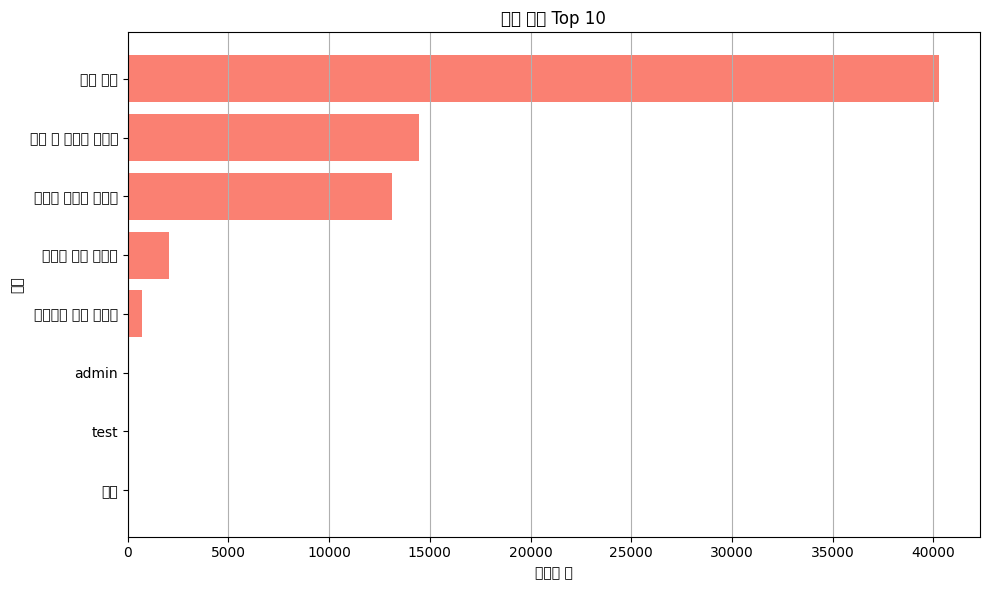

: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(top_reasons['탈퇴 사유'], top_reasons['탈퇴자 수'], color='salmon')
plt.gca().invert_yaxis() 
plt.title('탈퇴 사유 Top 10')
plt.xlabel('탈퇴자 수')
plt.ylabel('사유')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [22]:
summary[['johned counts', 'withdraws counts']].plot(kind='bar', figsize=(14,6), width=0.8)
plt.title('joined counts vs withdraws counts')
plt.xlabel('date')
plt.ylabel('counts')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

: 

: 

: 

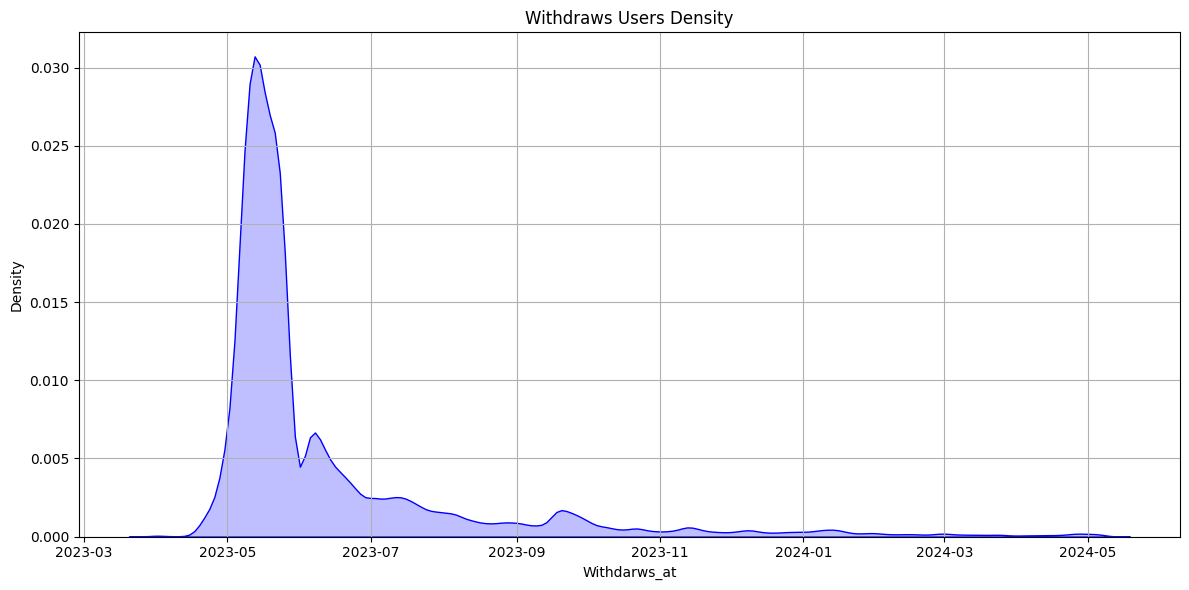

In [23]:
plt.figure(figsize=(12, 6))
sns.kdeplot(withdraws['created_at'], bw_adjust=0.5, fill=True, color='blue')
plt.title("Withdraws Users Density")
plt.xlabel("Withdarws_at")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()